In [50]:
!pip install featuretools

In [51]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier


import shap
from tqdm import tqdm
import featuretools as ft

import warnings 
warnings.filterwarnings('ignore')
import time

In [52]:
path = 'C:/Users/user/Desktop/kaggle_data/04. costa-rican-household-poverty-prediction/'

<br>

### 1. Check datasets
#### 1.1 Read dataset

In [53]:
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [54]:
print('df_train shape:', df_train.shape, '  ', 'df_test shape: ', df_test.shape)

df_train shape: (9557, 143)    df_test shape:  (23856, 142)


In [55]:
df_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [56]:
df_test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


<br>

#### 1.2 Make description df


<br>

#### 1.3 Check Null data

In [57]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis =1, keys = ['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
rez_esc,7928,82.954902
v18q1,7342,76.823271
v2a1,6860,71.779847
meaneduc,5,0.052318
SQBmeaned,5,0.052318
techozinc,0,0.000000
techoentrepiso,0,0.000000
techocane,0,0.000000
techootro,0,0.000000
cielorazo,0,0.000000


<br>

#### 1.4 Fill Missing values
- edjefe : 남자 교육 기간
- edjefa : 여자 교육 기간

In [58]:
df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "edjefa"] = df_train.loc[(df_train['edjefa'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]
df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "edjefe"] = df_train.loc[(df_train['edjefe'] == "yes") & (df_train['parentesco1'] == 1), "escolari"]

df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "edjefa"] = df_test.loc[(df_test['edjefa'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]
df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "edjefe"] = df_test.loc[(df_test['edjefe'] == "yes") & (df_test['parentesco1'] == 1), "escolari"]

# this field is supposed to be interaction between gender and escolari, but it isn't clear what "yes" means, let's fill it with 4
df_train.loc[df_train['edjefa'] == "yes", "edjefa"] = 4
df_train.loc[df_train['edjefe'] == "yes", "edjefe"] = 4

In [59]:
df_test.loc[df_test['edjefa'] == "yes", "edjefa"] = 4
df_test.loc[df_test['edjefe'] == "yes", "edjefe"] = 4

# create feature with max education of either head of household
df_train['edjef'] = np.max(df_train[['edjefa','edjefe']], axis=1)
df_test['edjef'] = np.max(df_test[['edjefa','edjefe']], axis=1)

# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toilet, 
# if there is no water we'll assume they do not
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "v14a"] = 0
df_train.loc[(df_train.v14a ==  1) & (df_train.sanitario1 ==  1) & (df_train.abastaguano == 0), "sanitario1"] = 0

df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "v14a"] = 0
df_test.loc[(df_test.v14a ==  1) & (df_test.sanitario1 ==  1) & (df_test.abastaguano == 0), "sanitario1"] = 0

<br>

**reaz_esz, SQBmeaned**
- `rez_esc` : years behind in school-> filled with 0
- `SQBmeaned` : square of the mean years of education of adults in the household ages, Age squared - > same with rez_esc -> filled with 0

In [60]:
df_train['rez_esc'].fillna(0, inplace = True)
df_test['rez_esc'].fillna(0, inplace = True)

In [61]:
df_train['SQBmeaned'].fillna(0, inplace = True)
df_test['SQBmeaned'].fillna(0, inplace = True)


<br>

**meaneduc**

- meaneduc : avearge years of education for adults

In [62]:
df_train['meaneduc'].fillna(0, inplace = True)
df_test['meaneduc'].fillna(0, inplace = True)

<br>

**v18q1**

- number of tablets household own

In [63]:
df_train.v18q.value_counts()

0    7342
1    2215
Name: v18q, dtype: int64

In [64]:
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [65]:
df_train.loc[df_train['v18q1'] == 0, 'v18q1'].value_counts()

Series([], Name: v18q1, dtype: int64)

In [66]:
df_train['v18q1'].fillna(0, inplace = True)
df_test['v18q1'].fillna(0, inplace = True)


<br>

**tipovivi3**

- rent or not

In [67]:
df_train['tipovivi3'].value_counts()

0    7821
1    1736
Name: tipovivi3, dtype: int64

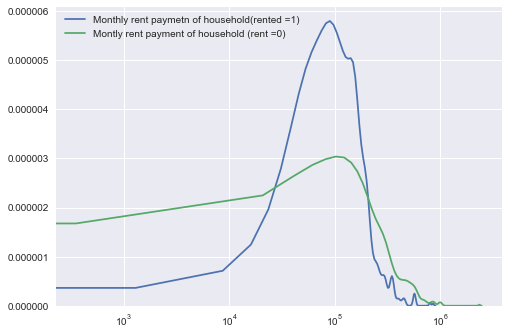

In [68]:
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, 'v2a1'], label = 'Monthly rent paymetn of household(rented =1)')
sns.kdeplot(df_train.loc[df_train['tipovivi3'] ==0, 'v2a1'], label = 'Montly rent payment of household (rent =0)')

plt.xscale('log')
plt.show()

In [69]:
df_train['v2a1'].fillna(0, inplace = True)
df_test['v2a1'].fillna(0, inplace = True)

In [70]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = 100 * (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending = False)

missing_df = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,9557,100.0
Target,0,0.0
sanitario3,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguano,0,0.0


In [71]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = 100 * (df_test.isnull().sum() / df_test.isnull().count()).sort_values(ascending=False)
missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_df.head(20)

,Total,Percent
edjef,23856,100.0
abastaguano,0,0.0
sanitario2,0,0.0
sanitario1,0,0.0
coopele,0,0.0
noelec,0,0.0
planpri,0,0.0
public,0,0.0
abastaguafuera,0,0.0
sanitario5,0,0.0


<br>

### 2. Feature Engineering

#### 2.1 Object features

In [72]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']

In [82]:
features_object = []
for col in df_train.select_dtypes('object'):
    features_object.append(col)

In [83]:
features_object

['Id', 'idhogar', 'edjefe', 'edjefa']

<br>

**dependency**

In [81]:
df_train['dependency'] = np.sqrt(df_train['SQBdependency'])
df_test['dependency'] = np.sqrt(df_test['SQBdependency'])

<br>

**edjefe**

In [84]:
def replace_edjefe(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefe'] = df_train['edjefe'].apply(replace_edjefe).astype(float)
df_test['edjefe'] = df_test['edjefe'].apply(replace_edjefe).astype(float)

<br>

**edjefa**

In [85]:
def replace_edjefa(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x
    
df_train['edjefa'] = df_train['edjefa'].apply(replace_edjefa).astype(float)
df_test['edjefa'] = df_test['edjefa'].apply(replace_edjefa).astype(float)

In [86]:
df_train['edjef'] = np.max(df_train[['edjefa', 'edjefe']], axis = 1)
df_test['edjef'] = np.max(df_test[['edjefa', 'edjefe']], axis = 1)


<br>

**roof and electricity**

In [87]:
df_train['roof_waste_material'] = np.nan
df_test['roof_waste_material'] = np.nan
df_train['electricity_other'] = np.nan
df_test['electricity_other'] = np.nan

In [88]:
def fill_roof_exception(x):
    if (x['techozinc'] ==0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
def fill_no_electricity(x):
    if (x['public'] ==0) and(x['planpri'] ==0) and (x['noelec'] ==0) and(x['coopele'] ==0):
        return 1
    else:
        return 0
    

In [89]:
df_train['roof_waste_material'] = df_train.apply(lambda x : fill_roof_exception(x), axis =1)
df_test['roof_waste_material'] = df_test.apply(lambda x : fill_roof_exception(x), axis =1)

df_train['electricity_other'] = df_train.apply(lambda x : fill_no_electricity(x), axis =1)
df_test['electriciy_other'] = df_test.apply(lambda x : fill_no_electricity(x), axis = 1)

<br>

### 2.2 Extract cat features

In [90]:
binary_cat_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] == 2]

<br>

### 2.3 Make new features using continuous feature